# Bitcoin Price Prediction Project



## 1. Data Cleaning and Preprocessing



In [1]:
# load all the libraries needed to work with the project here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
import os
import json
import math
import requests
import datetime
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

In [2]:
# read bitcoin pricing CSV into dataframe
btc_prices = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

In [3]:
# convert unix timestamps to date-time
btc_prices['Timestamp'] = pd.to_datetime(btc_prices['Timestamp'], unit='s')
btc_prices = btc_prices.set_index('Timestamp')

In [4]:
btc_prices.tail(10)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2021-03-30 23:51:00,58677.05,58699.90,58660.00,58699.90,2.672676,156832.692130,58680.021260
2021-03-30 23:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-30 23:53:00,58718.68,58731.23,58698.34,58698.50,0.207983,12209.055282,58702.294657
2021-03-30 23:54:00,58736.19,58762.43,58736.19,58739.95,0.041559,2441.376572,58745.145351
2021-03-30 23:55:00,58742.18,58742.18,58714.31,58714.31,2.519999,148004.448110,58731.946927
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


In [5]:
btc_average = btc_prices['Weighted_Price'].mean()
btc_median = btc_prices['Weighted_Price'].median()
btc_min = btc_prices['Weighted_Price'].min()
btc_max = btc_prices['Weighted_Price'].max()

print('Price statistics: ')
print('average:  {0:.2f} $'.format(btc_average))
print('median:   {0:.2f} $'.format(btc_median))
print('minimum:     {0:.2f} $'.format(btc_min))
print('maximum: {0:.2f} $'.format(btc_max))

Price statistics: 
average:  6008.93 $
median:   3596.80 $
minimum:     3.80 $
maximum: 61716.21 $


In [6]:
# forward fill the rows with NaN prices
cleaned_btc_prices = btc_prices.fillna(method="ffill") 

In [7]:
# remove not needed columns
cleaned_btc_prices = cleaned_btc_prices.drop(['Open', 'Close', 'Volume_(Currency)', 'Volume_(BTC)'], axis=1)

In [8]:
# resample prices to resolution of one price per hour and pad missing values with next valid one
resampled_btc_prices = cleaned_btc_prices.resample('1D').mean().pad()

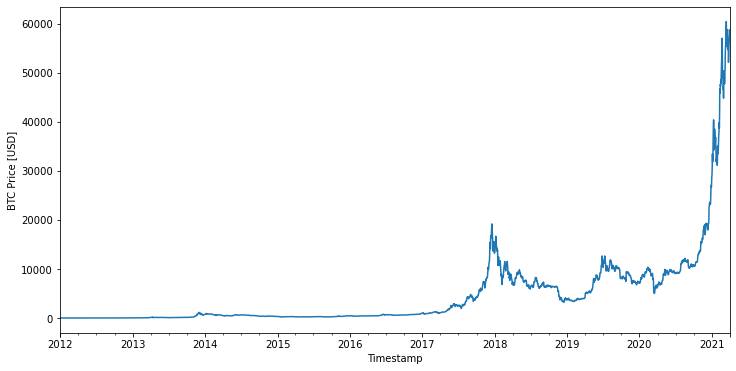

In [9]:
# plot the resulting graph of BTC prices in time

plt.figure(figsize=(12,6))
resampled_btc_prices['Weighted_Price'].plot()
plt.ylabel('BTC Price [USD]')
plt.show()

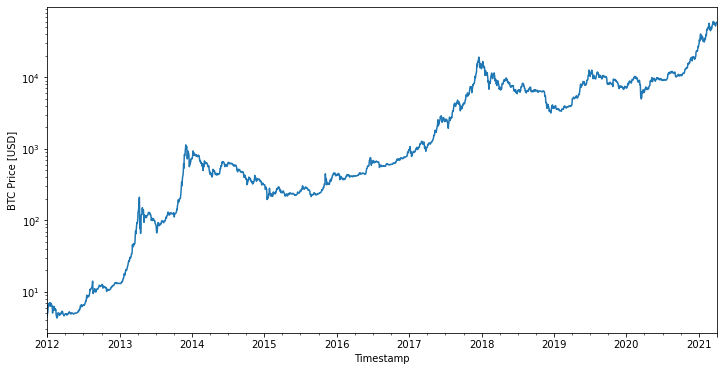

In [14]:
# plot the resulting graph of BTC prices in time (log scale)

plt.figure(figsize=(12,6))
resampled_btc_prices['Weighted_Price'].plot()
plt.ylabel('BTC Price [USD]')
plt.yscale('log')
plt.show()

In [79]:
# store resampled and cleaned records to file
resampled_btc_prices.to_csv('cleaned_resampled_btc_prices.csv',index_label='Timestamp')

In [64]:
# read cleaned and resampled BTC prices
btc_prices = resampled_btc_prices

In [55]:
# function to convert to JSON LD format which is needed for DeepAR
def timeseries_to_json_ld(df, column_index, excluded_context_length):
    return { 
        "start": df.index[0].strftime("%Y-%m-%d %H:%M:%S"), 
        "target": df.iloc[:df.shape[0] - excluded_context_length, column_index].to_numpy().tolist()
    } 

In [189]:
# function to create test and training JSON file for deepAR
columns = btc_prices.shape[1]

def write_dataframe_to_deep_AR_json_ld(df, file_name, excluded_context_length=0):
    with open(file_name, 'a') as json_file:
        for column_index in range(columns):
            json_line = json.dumps(timeseries_to_json_ld(df, column_index, excluded_context_length)) + '\n'
            json_file.write(json_line)

In [194]:
# Prediction length, lets make it 1 month
prediction_length = 30

# context length, lets make it 2 months
context_length = prediction_length * 2


In [ ]:
# create test dataset with complete data (as recommended in deepAR best practices)
write_dataframe_to_deep_AR_json_ld(btc_prices, 'data/test.json')

# create training dataset with complete data minus the prediction lenght (as recommended in deepAR best practices)
write_dataframe_to_deep_AR_json_ld(btc_prices, 'data/train.json', prediction_length)

In [4]:
# get sagemaker session, role and default S3 bucket
session = sagemaker.Session()
role = get_execution_role()

bucket = session.default_bucket()

In [69]:
prefix='bitcoin-prediction'
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# upload training and test dataset to S3
train_path  = session.upload_data('data/train.json', bucket=bucket, key_prefix=train_prefix)
test_path   = session.upload_data('data/test.json',  bucket=bucket, key_prefix=test_prefix)

In [70]:
print('Training location: '+ train_path)
print('Test location: '+ test_path)

Training location: s3://sagemaker-us-east-1-237845067016/bitcoin-prediction/train/train.json
Test location: s3://sagemaker-us-east-1-237845067016/bitcoin-prediction/test/test.json


## 2. Creating and Training the deepAR Model


In [192]:
# create an estimator instance for deepAR
image_uri = get_image_uri(boto3.Session().region_name, "forecasting-deepar")
s3_output_path = f"s3://{bucket}/{prefix}/output"

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=session,
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="bitcoin-predictor",
    output_path=s3_output_path
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [293]:
# set good hyper parameters

frequency = 'D' # 1 day frequency

hyperparameters = {
    "time_freq": frequency,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "100",
    "num_layers": "6",
    "likelihood": "student-T",
    "epochs": "200",
    "mini_batch_size": "32",
    # "learning_rate": "0.001",
    "dropout_rate": "0.15",
    "early_stopping_patience": "40"
}

estimator.set_hyperparameters(**hyperparameters)

In [294]:
# train the model

data_channels = {"train": train_path, "test": test_path}

estimator.fit(inputs=data_channels)

2021-10-26 15:00:19 Starting - Starting the training job...ProfilerReport-1635260419: InProgress
......
2021-10-26 15:01:34 Starting - Launching requested ML instances...............
2021-10-26 15:04:20 Starting - Preparing the instances for training...............
2021-10-26 15:06:34 Downloading - Downloading input data
2021-10-26 15:06:34 Training - Downloading the training image..Arguments: train
[10/26/2021 15:07:02 INFO 139626503206272] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,

Training Results

starting loss: 7.334874
Final loss: 4.602022239091721


#test_score (algo-1, RMSE): 4559.286415901311

#test_score (algo-1, mean_absolute_QuantileLoss): 252814.03333333335

#test_score (algo-1, mean_wQuantileLoss): 0.05119229787673776

#test_score (algo-1, wQuantileLoss[0.1]): 0.026615664524137515

#test_score (algo-1, wQuantileLoss[0.2]): 0.035788473100831684

#test_score (algo-1, wQuantileLoss[0.3]): 0.04361698768198024

#test_score (algo-1, wQuantileLoss[0.4]): 0.05539865067286393

#test_score (algo-1, wQuantileLoss[0.5]): 0.06399183037893764

#test_score (algo-1, wQuantileLoss[0.6]): 0.06572183859800423

#test_score (algo-1, wQuantileLoss[0.7]): 0.06510322582670063

#test_score (algo-1, wQuantileLoss[0.8]): 0.06001858800678422

#test_score (algo-1, wQuantileLoss[0.9]): 0.04447542210039976

#quality_metric: host=algo-1, test RMSE <loss>=4559.286415901311
    
#quality_metric: host=algo-1, test mean_wQuantileLoss <loss>=0.05119229787673776

bitcoin-predictor-2021-10-26-14-29-04-775	arn:aws:sagemaker:us-east-1:237845067016:endpoint/bitcoin-predictor-2021-10-26-14-29-04-775

## 3. Evaluate the Model


In [5]:
# load best model from S3
model = sagemaker.model.Model(
    image_uri='522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1',
    model_data='s3://sagemaker-us-east-1-237845067016/bitcoin-prediction/output/bitcoin-predictor-2021-10-26-14-14-12-340/output/model.tar.gz',
    role=role,
    sagemaker_session = session
)

In [6]:
# create a predictor for BTC
btc_predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

-------------!

In [326]:
# function to fetch latest BTC prices for evaluation of the model
days_of_prices = 90

def get_latest_btc_prices(): 
    response = requests.get('https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit={}'.format(days_of_prices - 1))
    json_prices = json.loads(response.text)
    return [ np.array([json_price['high'], json_price['low']]).mean() for json_price in json_prices['Data']['Data'] ]


In [327]:
# fetch latest prices
latest_prices = get_latest_btc_prices()

In [328]:
# function to create inference request with time series until 30 days ago
def create_inference_request(latest_prices):
    ts_start_timestamp = datetime.datetime.now() - datetime.timedelta(days=len(latest_prices))
    ts_prices = latest_prices[:-prediction_length]
    return { 
        "instances": [ { "start": ts_start_timestamp.strftime("%Y-%m-%d %H:%M:%S"), "target": ts_prices } ],
        "configuration": { "num_samples": 50, "output_types": ["mean", "quantiles", "samples"], "quantiles": ["0.1", "0.5", "0.9"] }
    }

In [ ]:
# predict prices
request = create_inference_request(latest_prices)
price_predictions = btc_predictor.predict(request)

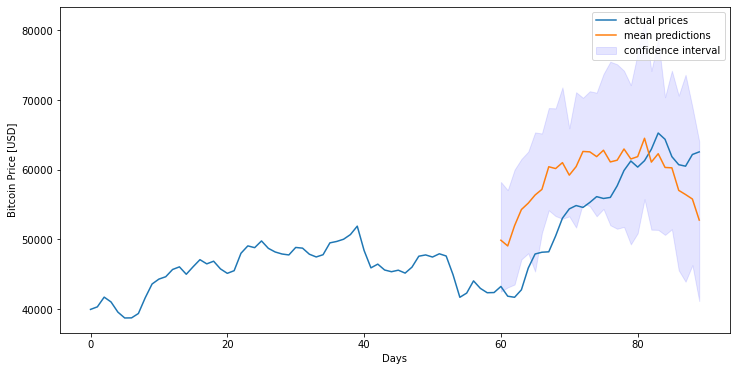

In [330]:
# visualize prediction results and compare to real values

def display_quantiles(price_predictions, actual_prices):
    mean_predictions = price_predictions['predictions'][0]['mean']
    quantile_10 = price_predictions['predictions'][0]['quantiles']['0.1']
    quantile_50 = price_predictions['predictions'][0]['quantiles']['0.5']
    quantile_90 = price_predictions['predictions'][0]['quantiles']['0.9']
    days = len(actual_prices)
    
    plt.figure(figsize=(12,6))
    plt.plot(range(days), actual_prices, label='actual prices')
    plt.plot(range(days - 30, days), mean_predictions, label='mean predictions')
    plt.fill_between(range(days - 30, days), quantile_10, quantile_90, color='b', alpha=.1, label='confidence interval')
    plt.xlabel('Days')
    plt.ylabel('Bitcoin Price [USD]')
    plt.legend()
    plt.show()
    
display_quantiles(price_predictions, latest_prices)

In [341]:
# calculate the symmetric mean absolute percentage error for comparison with the benchmarks

def calculate_SMAPE(forecasts, actual_prices):
    F = np.array(forecasts)
    A = np.array(actual_prices)
    n = len(forecasts)
    smape = (100 / n) * np.sum( np.abs(F - A) / (np.abs(A) + np.abs(F)) )
    return smape

bitcoin_predictor_sMAPE = calculate_SMAPE(price_predictions['predictions'][0]['mean'], latest_prices[context_length:])

print('The Bitcoin predictor scored an symmetric mean absolute percentage error of {:.2f}%'.format(bitcoin_predictor_sMAPE))

The Bitcoin predictor scored an symmetric mean absolute percentage error of 5.55%


## 4. Deployment and Web App


In [24]:
# prepare code for AWS Lambda
import boto3

runtime= boto3.client('runtime.sagemaker')



def lambda_handler(event, context):
    return create_prediction_response()
    
    
def create_prediction_response():
    days_of_prices = 60
    latest_prices = get_latest_btc_prices(days_of_prices)
    inference_request = create_inference_request(latest_prices)

    response = runtime.invoke_endpoint(EndpointName='forecasting-deepar-2021-10-29-06-44-53-190',
                                       ContentType='application/json',
                                       Body=inference_request)
    response_json = json.loads(response['Body'].read().decode('utf-8'))
    
    return format_response(response_json, latest_prices)
    
def get_latest_btc_prices(days_of_prices): 
    response = requests.get('https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit={}'.format(days_of_prices - 1))
    json_prices = json.loads(response.text)
    return [ np.array([json_price['high'], json_price['low']]).mean() for json_price in json_prices['Data']['Data'] ]

def create_inference_request(latest_prices):
    ts_start_timestamp = datetime.datetime.now() - datetime.timedelta(days=len(latest_prices))
    return json.dumps({ 
        "instances": [ { "start": ts_start_timestamp.strftime("%Y-%m-%d %H:%M:%S"), "target": latest_prices } ],
        "configuration": { "num_samples": 50, "output_types": ["mean", "quantiles", "samples"], "quantiles": ["0.1", "0.5", "0.9"] }
    })


In [43]:
def format_response(response, latest_prices): 
    mean_predictions = response['predictions'][0]['mean']
    quantile_10 = response['predictions'][0]['quantiles']['0.1']
    quantile_90 = response['predictions'][0]['quantiles']['0.9']
    now = datetime.datetime.now()
    historic_days = len(latest_prices)
    prediction_days = len(mean_predictions)
    
    # add past prices
    historic_timestamps = [(now - datetime.timedelta(days=historic_days - days)).strftime("%Y-%m-%d") for days in range(historic_days)]
    formated_response = [ {'x': historic_timestamps[day], 'y': latest_prices[day], 'group': 'historic'}  for day in range(historic_days)]
    
    # added latest actual price as prediction to have a nicer connection from current price to predictions in the graph
    formated_response.append({'x': historic_timestamps[historic_days-1], 'y': latest_prices[historic_days-1], 'group': 'pred_median'})
    
    # add predictions with quantiles
    prediction_timestamps = [(now + datetime.timedelta(days=days)).strftime("%Y-%m-%d") for days in range(prediction_days)]
    for day in range(prediction_days):
        formated_response.append({'x': prediction_timestamps[day], 'y': mean_predictions[day], 'group': 'pred_median'})
    for day in range(prediction_days):
        formated_response.append({'x': prediction_timestamps[day], 'y': quantile_10[day], 'group': 'pred_q10'})    
    for day in range(prediction_days):
        formated_response.append({'x': prediction_timestamps[day], 'y': quantile_90[day], 'group': 'pred_q90'})
    
    return formated_response

result = create_prediction_response()
